## 发病率(incidence)统计
统计每个州前五发病率国家

纵坐标：incidence rate

横坐标：年龄段(0-80)

数据间隔: 10

数据表达形式: 折线图形式

### 统计内容:
1. 黑色素肿瘤：5张图
2. 非黑色素肿瘤：5张图


### 头文件及配置

In [9]:
import os
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# 设置字体
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman'] + mpl.rcParams['font.serif']

# 内嵌矢量图
%config InlineBackend.figure_format = 'svg'

### 合并北美洲和南美洲的数据

In [ ]:

na_dir_name = "data/input/"
lac_dir_name= "data/input/"

 # 获取dir中的所有文件名
na_dir = [ f for f in os.listdir(na_dir_name) if f.startswith('na') ]
lac_dir = [ f for f in os.listdir(lac_dir_name) if f.startswith('lac') ]

america_directory = "data/input/"

# 创建america数据目录
if not os.path.exists(america_directory):
    os.makedirs(america_directory)

# 合并南美洲和北美洲的数据
for nafile in na_dir:

    measure = nafile.split('_')[1]
    cancer = nafile.split('_')[2]
    year = nafile.split('_')[3].split('.')[0]

    lacfile = f"lac_{measure}_{cancer}_{year}.json"

    # 构建目标文件名
    output_file_name = f"america_{measure}_{cancer}_{year}.json"
    output_file_path = os.path.join(america_directory, output_file_name)

    # 读取na json文件
    filepath = os.path.join(na_dir_name, nafile)
    with open(filepath, 'r', encoding='utf-8') as na_filp:
        data_na = json.load(na_filp)
    
    # 读取lac json文件
    if lacfile in lac_dir:
        filepath = os.path.join(lac_dir_name, lacfile)
        with open(filepath, 'r', encoding='utf-8') as lac_filp:
            data_lac = json.load(lac_filp)
    else:
        exit()
    
    data_merge = data_na + data_lac
    with open(output_file_path, "w", encoding="utf-8") as fout:
        json.dump(data_merge, fout, ensure_ascii=False, indent=4)

### 确定每个洲的前五国家函数

In [10]:

def top_five(region, measure, cancer):
    filepath = f'{region}_{measure}_{cancer}_total.json'
    dirpath = f'data/input/'

    with open(os.path.join(dirpath, filepath), "r", encoding="utf-8") as region:
        data = json.load(region)
    
    sorted_data = sorted(data, key=lambda x: x['asr'], reverse=True)
    top_five_labels = [item['label'] for item in sorted_data[:5]]
    return top_five_labels


### 画图函数

In [19]:
cancer_map = {'melanoma':'Melanoma of skin', 'nomelanoma':'Non-melanoma skin cancer'}
plt.rcParams['xtick.labelsize'] = 13  # 设置x轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 13  # 设置y轴刻度字体大小

def image_show(results, region, measure, cancer):
    # 转换数据为DataFrame
    df = pd.DataFrame(results).T.astype(float)
    df.index = df.index.astype(int)

    plt.figure(figsize=(12, 6.75))

    for country in df.columns:
        plt.plot(df.index, df[country], marker='o', markersize=4, label=country)

    plt.title(f"{region.capitalize()}({cancer_map[cancer]})", fontsize=18)
    plt.xlabel('Age(Years)', fontsize=15)
    plt.ylabel(f'{measure.capitalize()} rate(1/100,000 population)', fontsize=15)

    # 添加图例
    plt.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.10),
        # fancybox=True,
        frameon=False,
        shadow=False, 
        ncol=5,
        fontsize=13
    )

    # 获取当前轴
    ax = plt.gca()

    # 移除上侧和右侧的边界线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 网格
    plt.grid(False)

    # 保存为svg格式
    plt.savefig(f'data/output/svg/{region}_{measure}_{cancer}.svg', format='svg', bbox_inches='tight')

    plt.show()

### 根据前五国家的Label，统计各个年龄段的数据，并绘制图像

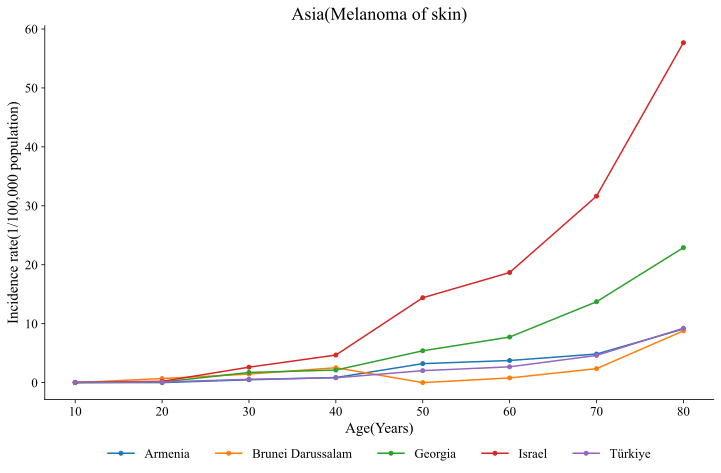

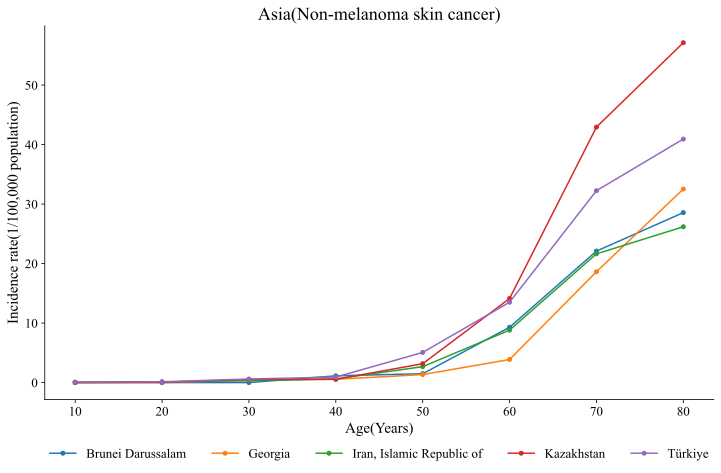

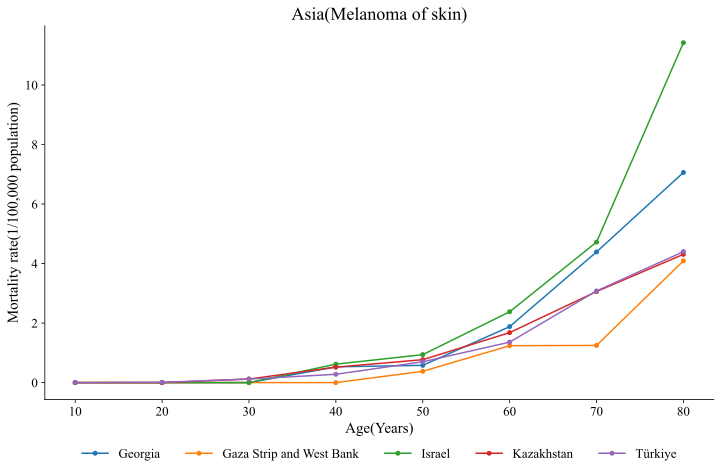

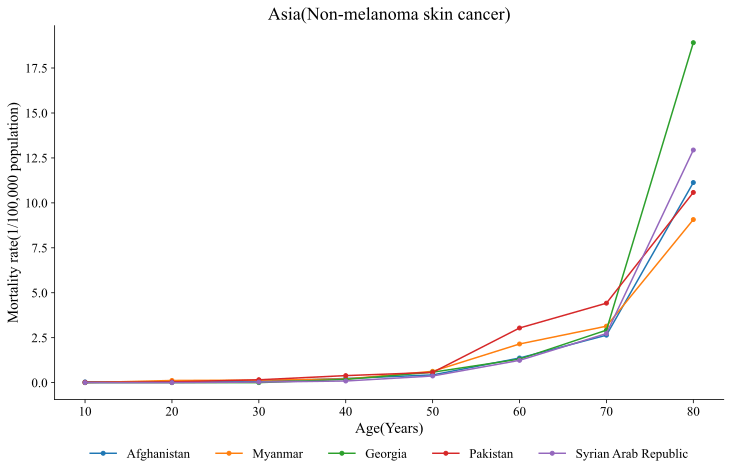

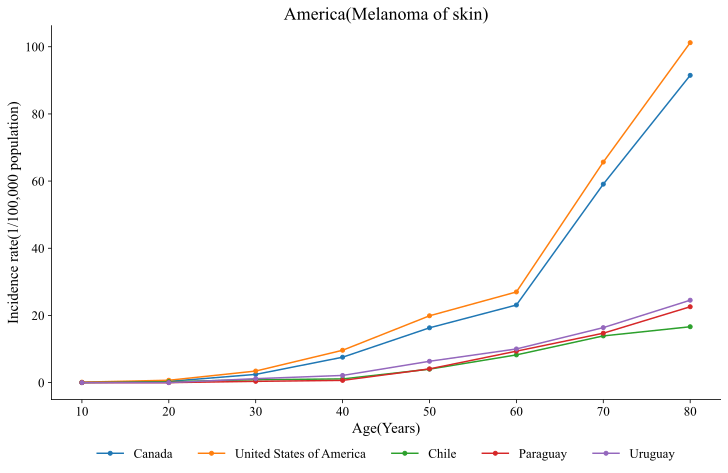

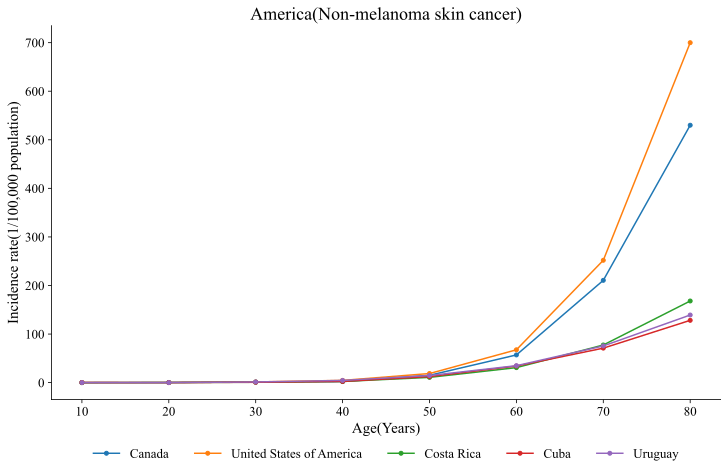

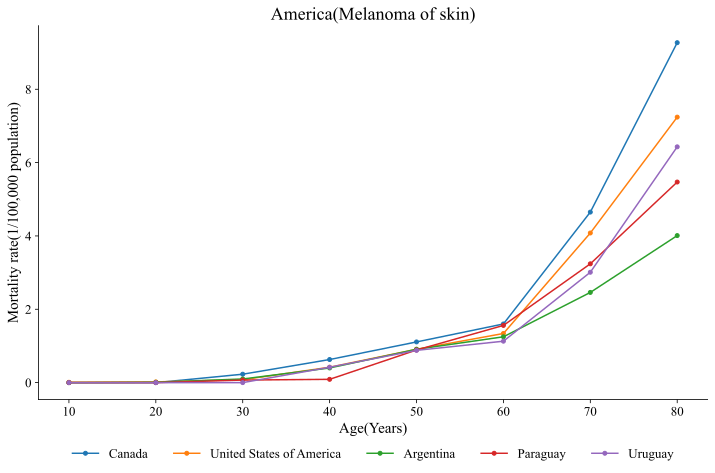

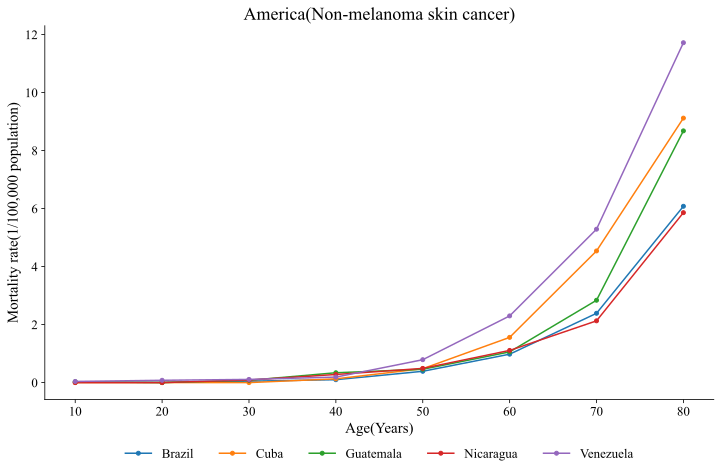

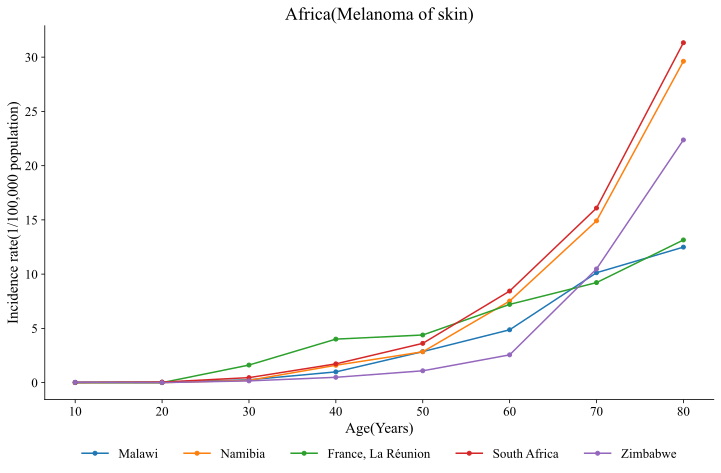

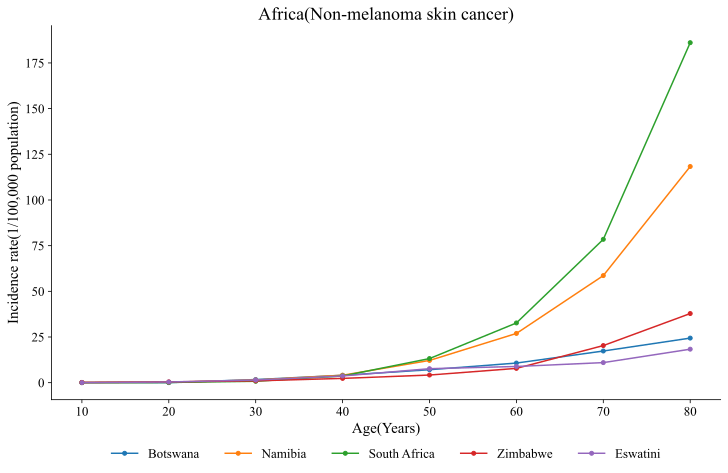

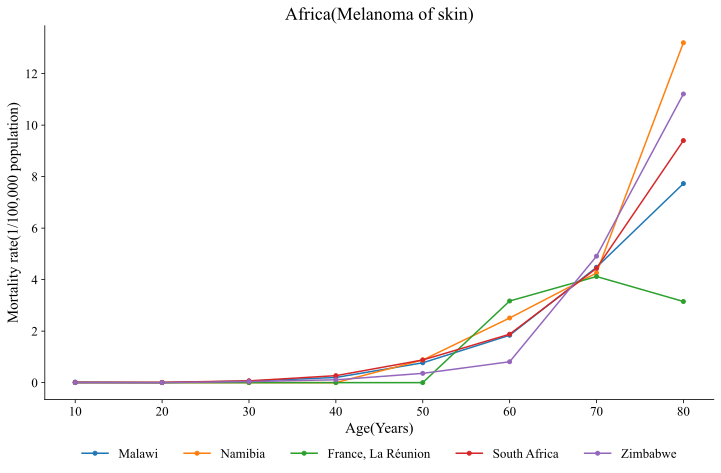

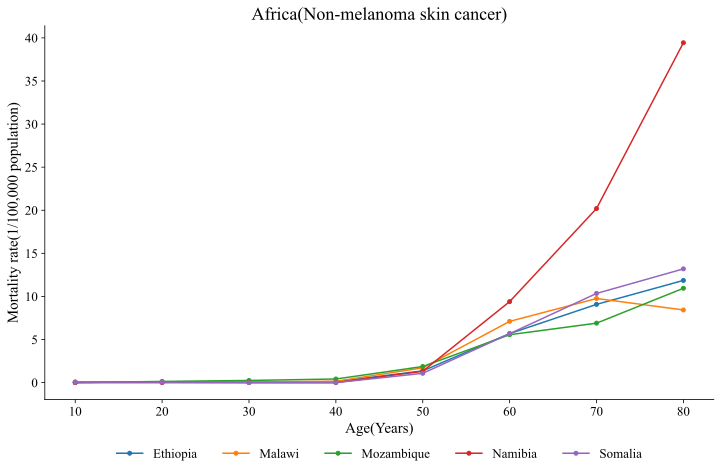

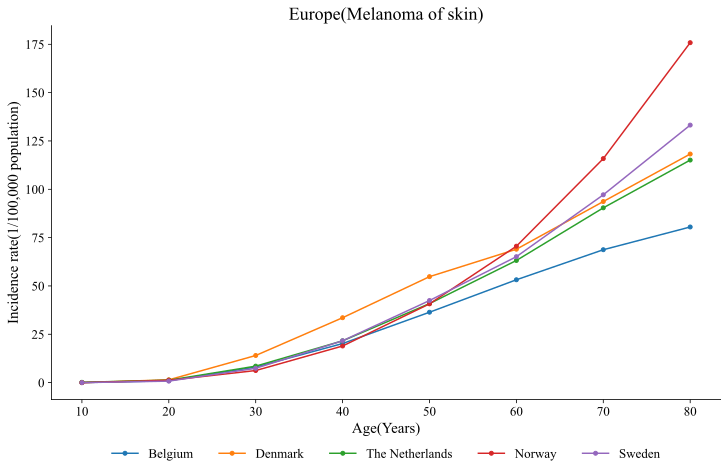

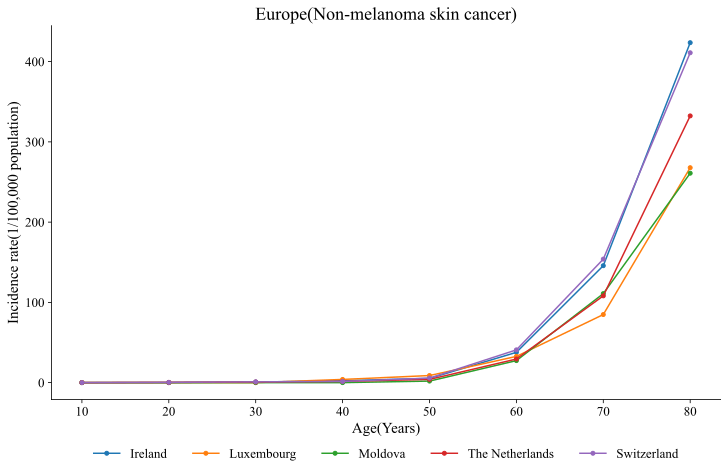

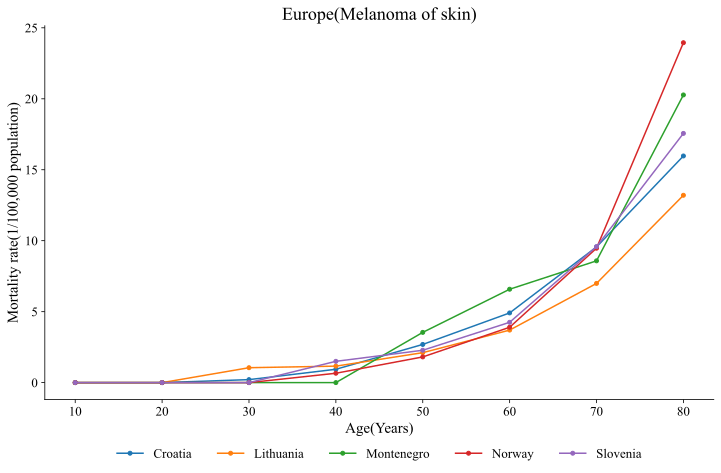

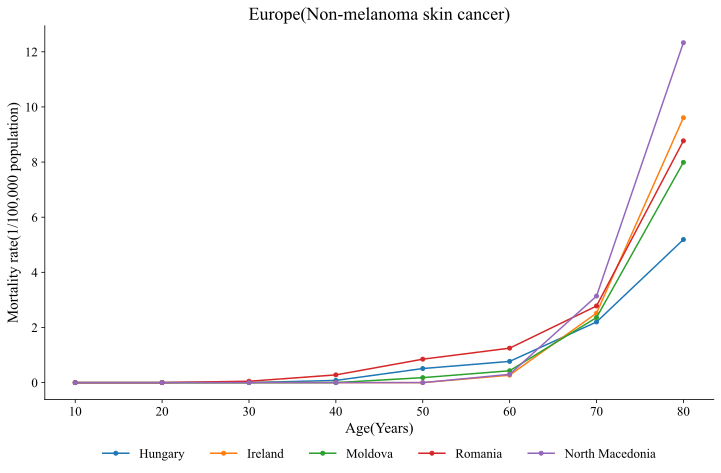

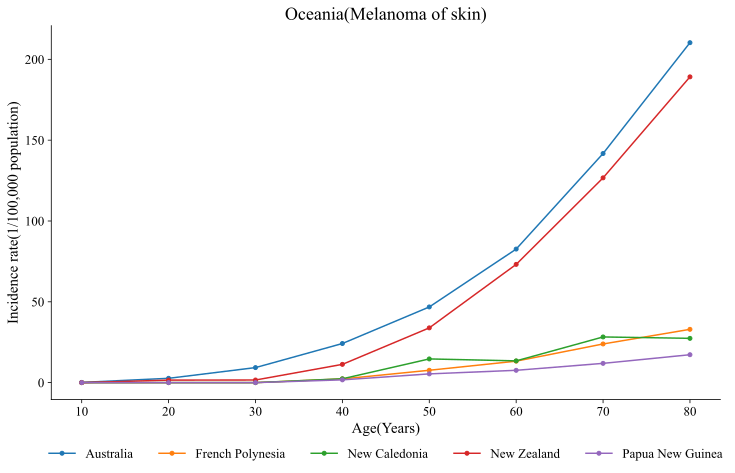

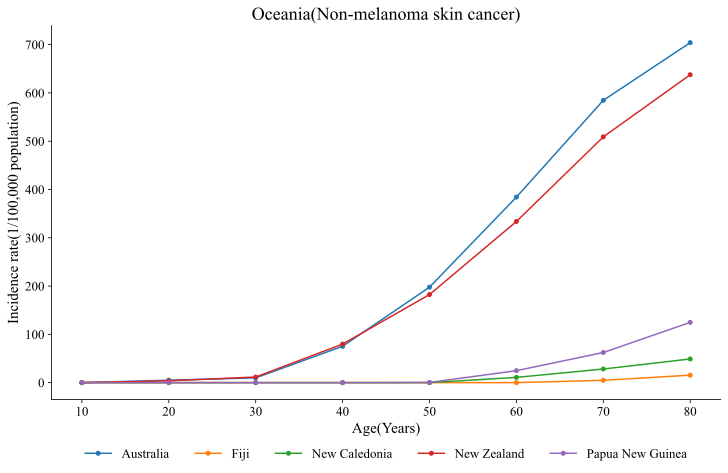

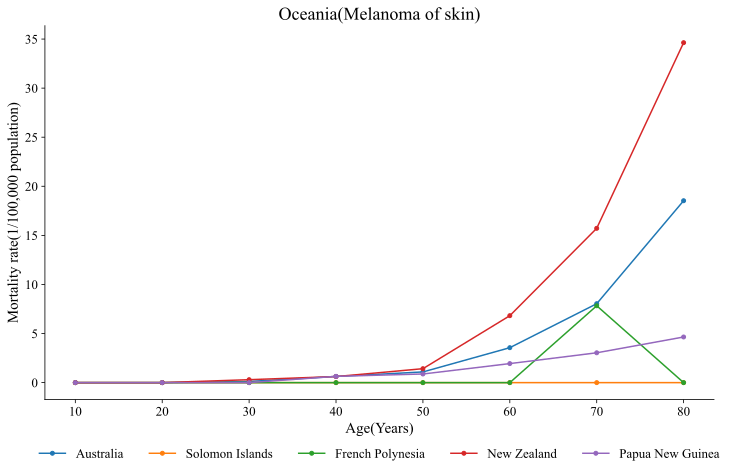

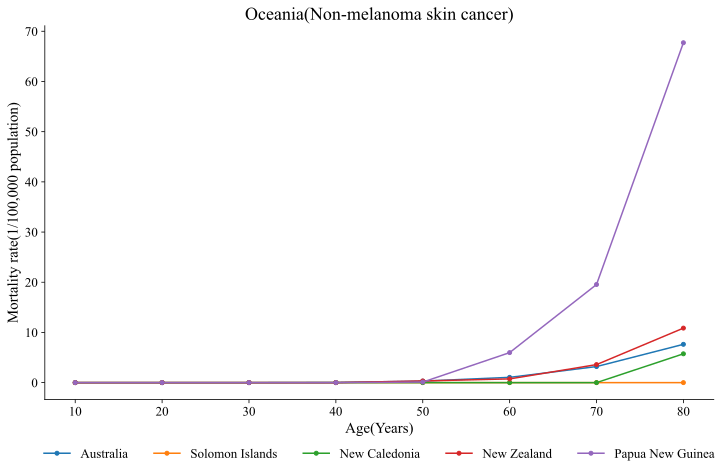

In [20]:

regions = ['asia', 'america', 'africa', 'europe', 'oceania']
measures = ['incidence', 'mortality']
cancers = ['melanoma', 'nomelanoma']

# 遍历每个地区
for region in regions:
    for measure in measures:
        for cancer in cancers:

            # 获取前五个国家的label
            top_five_labels = top_five(region, measure, cancer)

            # 输出结果和输入目录
            results = {}
            data_dir = f'data/input/'

            file_pattern = f"{region}_{measure}_{cancer}"

            # 遍历文件夹内的数据文件
            for filename in os.listdir(data_dir):
                if not filename.startswith(file_pattern):
                    continue
                if filename.endswith('total.json'):
                    continue

                year = filename.split('_')[3].split('.')[0]

                # 读取json文件
                filepath = os.path.join(data_dir, filename)
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                if year not in results:
                    results[year] = {}
                
                # 存储asr数据
                for item in data:
                    if item['label'] in top_five_labels:
                        results[year][item['label']] = item['asr']
            
            # 按年份排序
            years = list(results.keys())
            years.sort(key=int)

            results = {year: results[year] for year in years}

            with open(f'data/output/json/{region}_{measure}_{cancer}.json', 'w', encoding='utf-8') as f:
                json.dump(results, f, ensure_ascii=False, indent=4)
            
            image_show(results, region, measure, cancer)
